# Exploratory Data Analysis

- [Accéder aux bases](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/)
- [Accéder à la documentation](https://www.data.gouv.fr/fr/datasets/r/8ef4c2a3-91a0-4d98-ae3a-989bde87b62a)

# Objectifs : prédire la gravité d'un accident

La gravité d'un accident est codée par la variable `grav`, présente (uniquement) dans la base _usagers_, qui peut prendre les valeurs suivantes :
- 1 : indemne ;
- 2 : tué ;
- 3 : blessé hospitalisé ;
- 4 : blessé léger.

On charge dans un premier temps tous les packages nécessaires.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Sur data.gouv, quatre bases de données sont publiées annuellement. Elles concernent : les usages, les véhicules, les lieux et les caractéristiques. Nous chargeons ci-dessous les quatre bases de 2021 (les plus récentes).

In [2]:
df_usagers_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8", sep=";")
df_vehicules_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/c9742921-4427-41e5-81bc-f13af8bc31a0", sep=";")
df_lieux_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995", sep=";")
df_caracs_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5fc299c0-4598-4c29-b74c-6a67b0cc27e7", sep=";")

df_usagers_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/ba5a1956-7e82-41b7-a602-89d7dd484d7a", sep=";")
df_vehicules_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0bb5953a-25d8-46f8-8c25-b5c2f5ba905e", sep=";")
df_lieux_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8a4935aa-38cd-43af-bf10-0209d6d17434", sep=";")
df_caracs_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/85cfdc0c-23e4-4674-9bcd-79a970d7269b", sep=";")

df_usagers_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/78c45763-d170-4d51-a881-e3147802d7ee", sep=";")
df_vehicules_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a66be22f-c346-49af-b196-71df24702250", sep=";")
df_lieux_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e85c41f7-d4ea-4faf-877f-ab69a620ce21", sep=";")
df_caracs_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/07a88205-83c1-4123-a993-cba5331e8ae0", sep=";")

df_usagers_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028", sep=";")
df_vehicules_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/780cd335-5048-4bd6-a841-105b44eb2667", sep=";")
df_lieux_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/2ad65965-36a1-4452-9c08-61a6c874e3e6", sep=";")
df_caracs_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a", sep=";")

c:\Users\nahta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [71]:
from data_cleaning import *

In [68]:
from data_cleaning import *

In [72]:
df_usagers_22 = clean_df_usagers(df_usagers_22)
df_vehicules_22 = clean_df_vehicules(df_vehicules_22)
df_lieux_22 = clean_df_lieux(df_lieux_22)
df_caracs_22 = clean_df_caracs(df_caracs_22)

df_usagers_21 = clean_df_usagers(df_usagers_21)
df_vehicules_21 = clean_df_vehicules(df_vehicules_21)
df_lieux_21 = clean_df_lieux(df_lieux_21)
df_caracs_21 = clean_df_caracs(df_caracs_21)

df_usagers_20 = clean_df_usagers(df_usagers_20)
df_vehicules_20 = clean_df_vehicules(df_vehicules_20)
df_lieux_20 = clean_df_lieux(df_lieux_20)
df_caracs_20 = clean_df_caracs(df_caracs_20)

df_usagers_19 = clean_df_usagers(df_usagers_19)
df_vehicules_19 = clean_df_vehicules(df_vehicules_19)
df_lieux_19 = clean_df_lieux(df_lieux_19)
df_caracs_19 = clean_df_caracs(df_caracs_19)

In [74]:
clean_df_usagers(df_usagers_19)

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,201900000001,138 306 524,B01,2,passager,4,femme,2002,NaN,1.0,0.0,NaN,NaN,-1,NaN
1,201900000001,138 306 524,B01,1,conducteur,4,femme,1993,promenade-loisirs,1.0,0.0,NaN,NaN,-1,NaN
2,201900000001,138 306 525,A01,1,conducteur,1,homme,1959,NaN,1.0,0.0,NaN,NaN,-1,NaN
3,201900000002,138 306 523,A01,1,conducteur,4,femme,1994,NaN,1.0,0.0,NaN,NaN,-1,NaN
4,201900000003,138 306 520,A01,1,conducteur,1,homme,1996,NaN,1.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132972,201900058837,137 982 135,C01,1,conducteur,4,femme,1988,domicile-travail,1.0,0.0,NaN,NaN,-1,NaN
132973,201900058838,137 982 132,A01,1,conducteur,4,homme,1998,autre,1.0,0.0,NaN,NaN,-1,NaN
132974,201900058839,137 982 131,A01,1,conducteur,3,homme,1979,NaN,2.0,0.0,NaN,NaN,-1,NaN
132975,201900058840,137 982 129,B01,1,conducteur,4,homme,1974,NaN,1.0,0.0,NaN,NaN,NaN,NaN


# Jointure

On s'assure qu'on a bien autant d'observations dont le triplet `(Num_Acc, id_vehicule, num_veh)` est unique dans les bases `usagers` et `véhicules`.

In [5]:
(~df_usagers_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

In [6]:
(~df_vehicules_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

À présent, on peut procéder à la jointure à l'aide de `pd.merge`. On joint d'abord les bases `usagers` et `vehicules` sur `(Num_Acc, id_vehicule, num_veh)`, puis on joint également les bases `lieux` et `caracs` sur l'identifiant de l'accident, codé par `Num_Acc`.

In [7]:
df_merged_22 = pd.merge(pd.merge(pd.merge(df_usagers_22, df_vehicules_22, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_22, on="Num_Acc"), df_caracs_22, on="Num_Acc")

In [8]:
len(df_merged_22)

126662

On retombe bien sur un total de 126 662 observations, soit la longueur de la base usagers.

On fait de même pour les autres années (2021).

In [9]:
df_merged_21 = pd.merge(pd.merge(pd.merge(df_usagers_21, df_vehicules_21, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_21, on="Num_Acc"), df_caracs_21, on="Num_Acc")

df_merged_20 = pd.merge(pd.merge(pd.merge(df_usagers_20, df_vehicules_20, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_20, on="Num_Acc"), df_caracs_20, on="Num_Acc")

df_merged_19 = pd.merge(pd.merge(pd.merge(df_usagers_19, df_vehicules_19, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_19, on="Num_Acc"), df_caracs_19, on="Num_Acc")

In [10]:
df_merged = pd.concat([df_merged_22, df_merged_21, df_merged_20, df_merged_19], ignore_index=True)

In [11]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494182 entries, 0 to 494181
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      494182 non-null  int64  
 1   id_usager    255910 non-null  object 
 2   id_vehicule  494182 non-null  object 
 3   num_veh      494182 non-null  object 
 4   place        494157 non-null  float64
 5   catu         494182 non-null  object 
 6   grav         493881 non-null  float64
 7   sexe         488376 non-null  object 
 8   an_nais      488241 non-null  float64
 9   trajet       360809 non-null  object 
 10  secu1        488591 non-null  float64
 11  secu2        300673 non-null  float64
 12  secu3        5594 non-null    float64
 13  locp         277429 non-null  float64
 14  actp         222449 non-null  object 
 15  etatp        37936 non-null   object 
 16  senc         492526 non-null  float64
 17  catv         493108 non-null  float64
 18  obs          493991 non-

# Nettoyages

On recode la variable équipement pour obtenir des dummies plutôt que d'avoir trois variables `secu1`, `secu2`, `secu3`.

In [12]:
for equipement in ["ceinture", "casque", "dispositif enfants", "gilet réfléchissant",
                   "airbag", "gants", "gants + airbag", "autre"]:
    df_merged[equipement] = df_merged[["secu1", "secu2", "secu3"]].isin([equipement]).any(axis=1)

df_merged["airbag"] = df_merged["airbag"] | df_merged["gants + airbag"]
df_merged["gants"] = df_merged["gants"] | df_merged["gants + airbag"]
df_merged.drop("gants + airbag", axis=1, inplace=True)

c:\Users\nahta\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [56]:
df_merged["secu1"]

0         2.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
494177    1.0
494178    1.0
494179    2.0
494180    1.0
494181    1.0
Name: secu1, Length: 486837, dtype: float64

In [13]:
df_merged.replace(-1, np.nan, inplace=True)

On recode la gravité pour qu'elle soit "croissante".

In [14]:
df_merged["grav"].replace({2: 4, 4: 2}, inplace=True)

Eliminons d'emblée certaines variables qui ne serviront pas au modèle de prédiction de la gravité.

In [15]:
df_merged.columns

Index(['Num_Acc', 'id_usager', 'id_vehicule', 'num_veh', 'place', 'catu',
       'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'locp',
       'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'occutc', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof',
       'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ',
       'vma', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int',
       'atm', 'col', 'adr', 'lat', 'long', 'heure', 'ceinture', 'casque',
       'dispositif enfants', 'gilet réfléchissant', 'airbag', 'gants',
       'autre'],
      dtype='object')

In [16]:
df_merged.drop(["Num_Acc", "id_usager", "id_vehicule", "num_veh", "voie", "v1", "v2",
                "dep", "com", "adr", "lat", "long"], axis=1, inplace=True)

**[WARNING : pas forcément une bonne idée car `catu` est parfois peut-être plus pertinent que `place`]**
On élimine également la variable `catu` qui posera des problèmes de colinéarité, car son information est redondante par rapport à la variable `place`.

In [17]:
# df_merged.drop("catu", axis=1, inplace=True)

## Colonnes restantes

In [18]:
df_merged.columns

Index(['place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2',
       'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'occutc', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'pr',
       'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'vma',
       'jour', 'mois', 'an', 'hrmn', 'lum', 'agg', 'int', 'atm', 'col',
       'heure', 'ceinture', 'casque', 'dispositif enfants',
       'gilet réfléchissant', 'airbag', 'gants', 'autre'],
      dtype='object')

Description des variables
- `place` : place occupée dans le véhicule par l'usager au moment de l'accident ; 1 conducteur, 10 piéton
- `sexe` : sexe de l'usager
- `an_nais` : année de naissance de l'usager
- `trajet` : motif du déplacement au moment de l'accident
- `secu` : présence et utilisation de tel équipement de sécurité
- `locp` : localisation du piéton
- `actp` : action du piéton
- `etatp` : piéton seul, accompagné ou en groupe
- `senc` : sens de circulation
- `catv` : catégorie du véhicule
- `obs` : obstacle fixe heurté
- `obsm` : obstacle mobile heurté
- `choc` : point de choc initial

# Statistiques descriptives

### Variable `agg`

On constate que
- la majorité des accidents de gravité 1 et 2 ont lieu en agglomération ;
- la majorité des accidents de gravité 3 et 4 ont lieu hors agglomération.

<AxesSubplot:xlabel='agg', ylabel='count'>

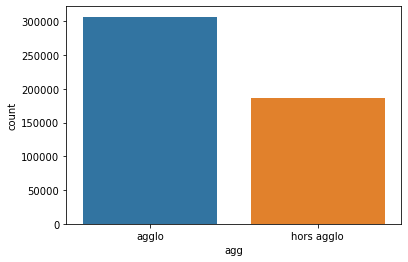

In [19]:
sns.countplot(data=df_merged, x="agg")

<AxesSubplot:xlabel='agg', ylabel='proportion'>

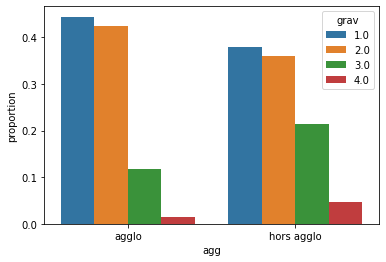

In [20]:
proportions = df_merged.groupby('agg')['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x='agg', y='proportion', hue='grav', data=proportions)

### Variable `place`

<AxesSubplot:xlabel='place', ylabel='count'>

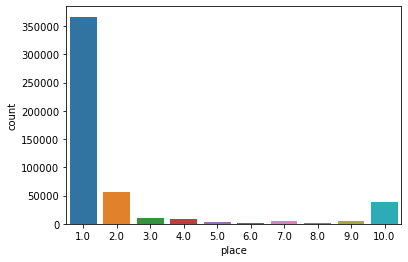

In [21]:
sns.countplot(data=df_merged, x="place")

<AxesSubplot:xlabel='place', ylabel='proportion'>

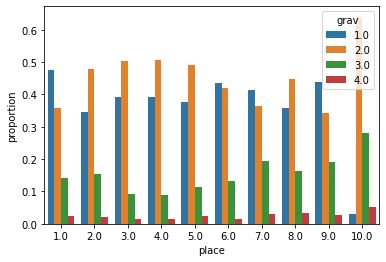

In [22]:
var = "place"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### Variable `catu`

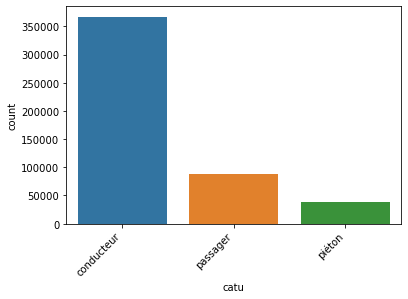

In [23]:
var = "catu"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

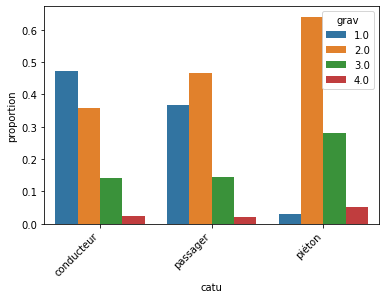

In [24]:
var = "catu"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### Variable `sexe`

<AxesSubplot:xlabel='sexe', ylabel='count'>

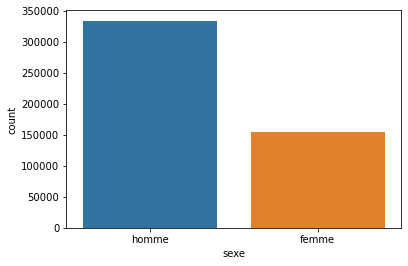

In [25]:
sns.countplot(data=df_merged, x="sexe")

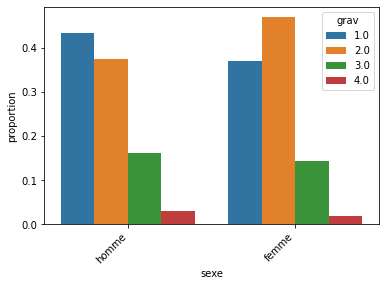

In [26]:
var = "sexe"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### Variable `an_nais` (année de naissance)

<AxesSubplot:xlabel='an_nais', ylabel='Density'>

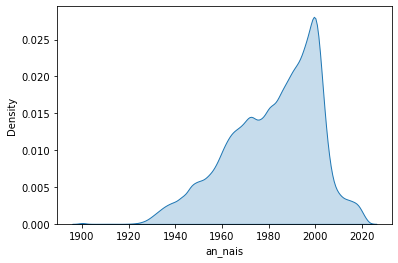

In [27]:
var = "an_nais"
sns.kdeplot(df_merged[var], fill=True)

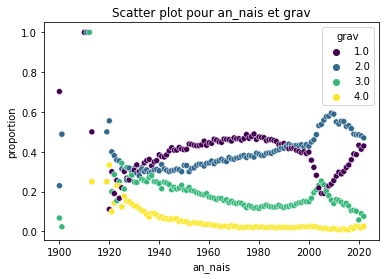

In [28]:
var = "an_nais"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

In [29]:
df_merged = df_merged[df_merged["an_nais"] >= 1930]

In [30]:
df_merged["ind_avant_1960"] = df_merged["an_nais"] < 1960
df_merged["ind_2002_2012"] = (df_merged["an_nais"] >= 2002) & (df_merged["an_nais"] <= 2012)

### Variable `nbv`

<AxesSubplot:xlabel='nbv', ylabel='count'>

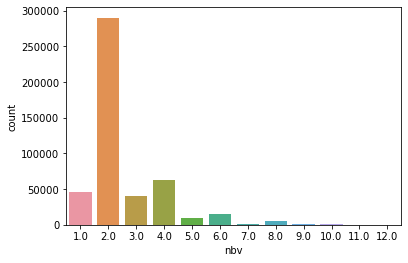

In [31]:
sns.countplot(data=df_merged, x="nbv")

<AxesSubplot:xlabel='nbv', ylabel='proportion'>

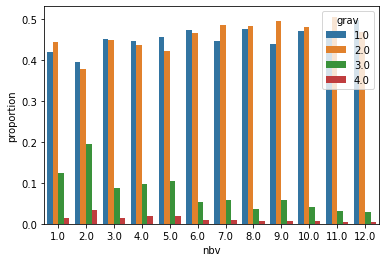

In [32]:
var = "nbv"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### Variable `trajet`

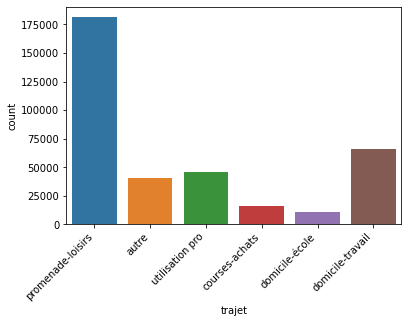

In [33]:
sns.countplot(data=df_merged, x="trajet")
plt.xticks(rotation=45, ha='right')
plt.show()

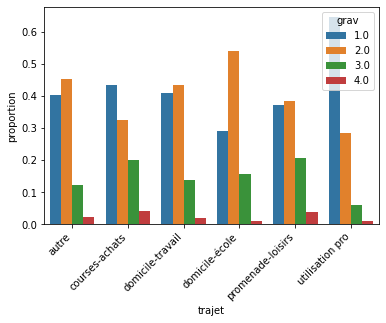

In [34]:
var = "trajet"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)
plt.xticks(rotation=45, ha='right')
plt.show()

### Variable `choc`

<AxesSubplot:xlabel='choc', ylabel='count'>

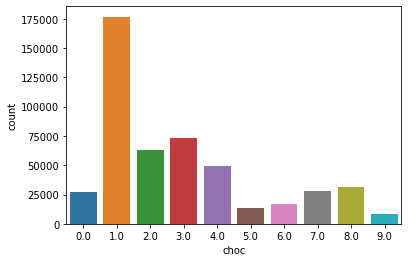

In [35]:
sns.countplot(data=df_merged, x="choc")

<AxesSubplot:xlabel='choc', ylabel='proportion'>

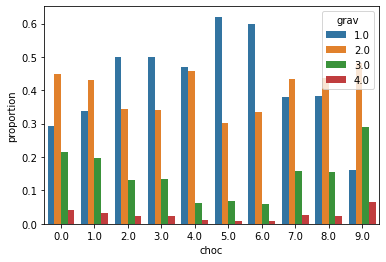

In [36]:
var = "choc"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### Variable `lum`

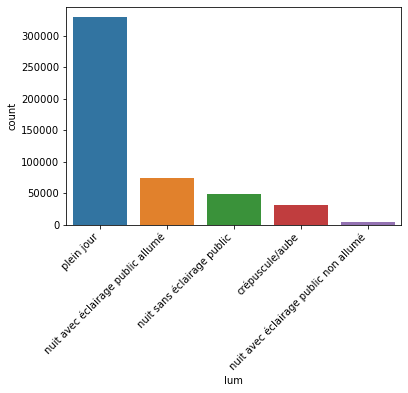

In [37]:
var = "lum"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

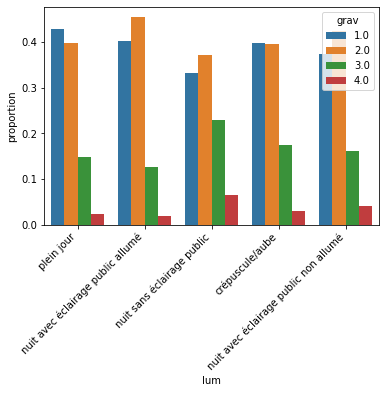

In [38]:
var = "lum"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [39]:
df_merged["lum_2"] = np.where(df_merged["lum"].isin(["plein jour", "nuit avec éclairage public allumé"]), 1, 0)

### Variable `surf` (surface)

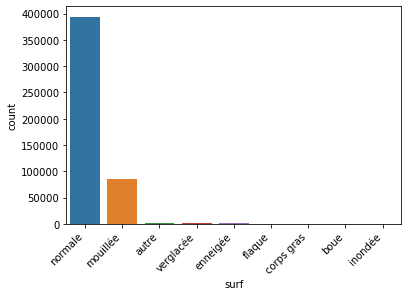

In [40]:
var = "surf"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

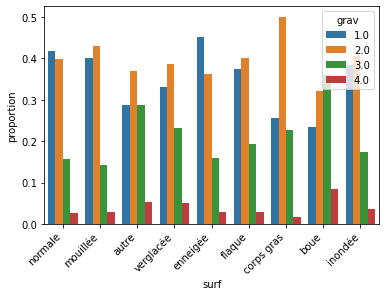

In [41]:
var = "surf"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### Variable `atm` (conditions atmosphériques)

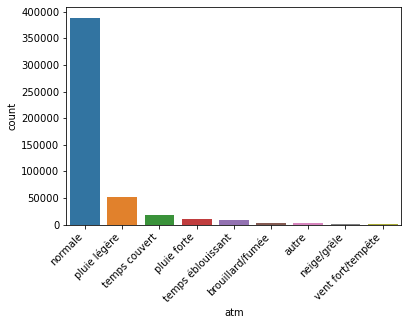

In [42]:
var = "atm"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

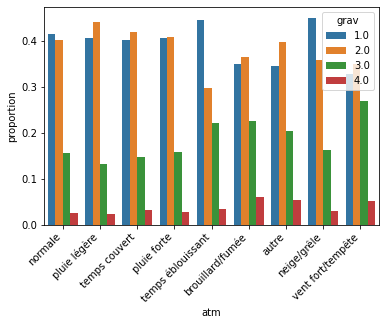

In [43]:
var = "atm"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### Variable `int` (intersection)

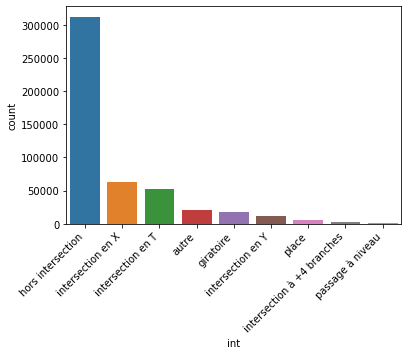

In [44]:
var = "int"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

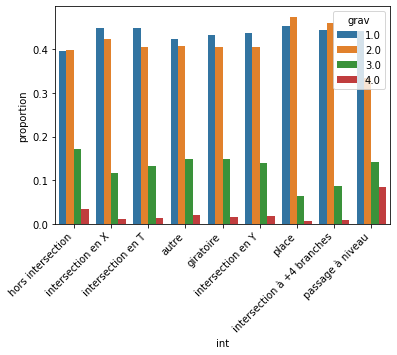

In [45]:
var = "int"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### Variable `col` (collision)

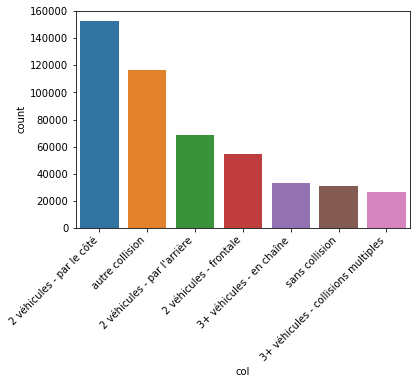

In [46]:
var = "col"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

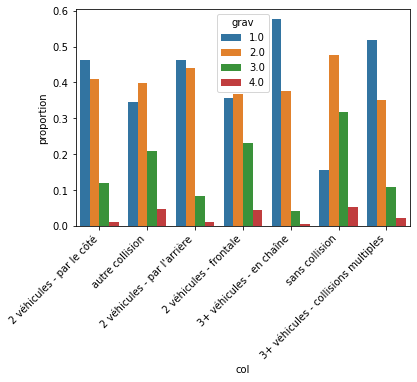

In [47]:
var = "col"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [48]:
df_merged["col_2"] = np.where(df_merged["col"].isin(["autre collision", "2 véhicules - frontale", "sans collision"]), 1, 0)

### Variable `catr` (catégorie route)

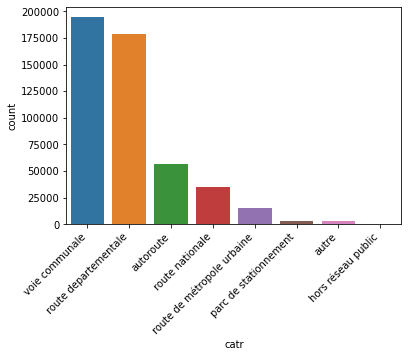

In [49]:
var = "catr"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

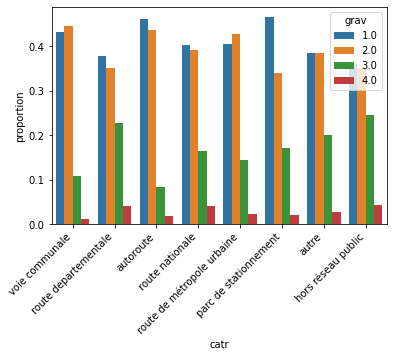

In [50]:
var = "catr"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [51]:
df_merged["catr_2"] = np.where(df_merged["catr"].isin(["route départementale", "hors réseau public"]), 0,
                               np.where(df_merged["catr"].isin(["route nationale", "route de métropole urbaine",
                                                               "parc de stationnement", "autre"]), 1, 2))

## Equipements

<AxesSubplot:xlabel='ceinture', ylabel='count'>

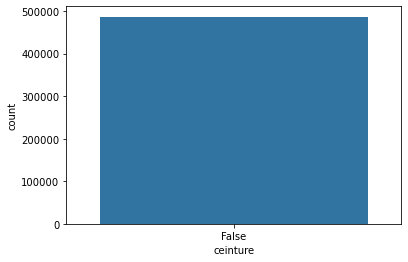

In [54]:
var = "ceinture"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)

<AxesSubplot:xlabel='ceinture', ylabel='proportion'>

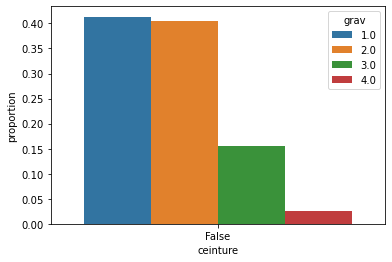

In [53]:
var = "ceinture"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)

# Premiers modèles

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### KNeighbors

In [57]:
numeric_features = ["an_nais", "vma"]
categorical_features = ["agg", "catu", "lum_2", "trajet", "sexe", "col_2", "catr_2", "ind_avant_1960", "ind_2002_2012"]


df_elem1 = df_merged[["grav"] + numeric_features + categorical_features]

df_elem1.dropna(inplace=True)

df_elem1

c:\Users\nahta\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,grav,an_nais,vma,agg,catu,lum_2,trajet,sexe,col_2,catr_2,ind_avant_1960,ind_2002_2012
0,3.0,2008.0,50.0,agglo,conducteur,1,promenade-loisirs,homme,0,2,False,True
1,1.0,1948.0,50.0,agglo,conducteur,1,promenade-loisirs,homme,0,2,True,False
2,2.0,1988.0,50.0,agglo,conducteur,1,autre,homme,0,2,False,False
3,1.0,1970.0,50.0,agglo,conducteur,1,utilisation pro,homme,0,2,False,False
5,2.0,1987.0,50.0,agglo,conducteur,1,autre,femme,0,2,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968.0,130.0,hors agglo,passager,1,promenade-loisirs,homme,0,2,False,False
494175,1.0,1972.0,90.0,hors agglo,conducteur,1,domicile-travail,femme,0,2,False,False
494176,2.0,1964.0,90.0,hors agglo,conducteur,1,domicile-travail,homme,0,2,False,False
494177,2.0,1988.0,90.0,hors agglo,conducteur,1,domicile-travail,femme,0,2,False,False


In [58]:
from sklearn.neighbors import KNeighborsClassifier

# Supposons que vous ayez un DataFrame df_elem1 avec les colonnes nécessaires
# Remplacez cela par votre DataFrame réel

# Séparation des features (X) et de la variable cible (y)

X = df_elem1.drop("grav", axis=1)
y = df_elem1["grav"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un transformateur pour les variables continues et catégorielles



In [59]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Créer le pipeline SVC avec le préprocesseur
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.48


### SVC

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Supposons que vous ayez un DataFrame df_elem1 avec les colonnes nécessaires
# Remplacez cela par votre DataFrame réel

# Séparation des features (X) et de la variable cible (y)
X = df_elem1.drop("grav", axis=1)
y = df_elem1["grav"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un transformateur pour les variables continues et catégorielles
numeric_features = ["an_nais", "vma"]
categorical_features = ["place", "lum"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Créer le pipeline SVC avec le préprocesseur
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear'))  # Vous pouvez choisir un autre noyau selon vos besoins
])

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.48
